In [1]:
%%capture
%cd ../../
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from ml_common.constants import DRUG_COLS
from ml_common.util import get_nmissing

from preduce.util import load_clinic_dates

pd.set_option('display.max_rows', 150)

# Quick EDA of clinic notes

In [7]:
clinic = load_clinic_dates(data_dir='./data/processed')

Removing 123 visits that "occured before" 2006-01-05


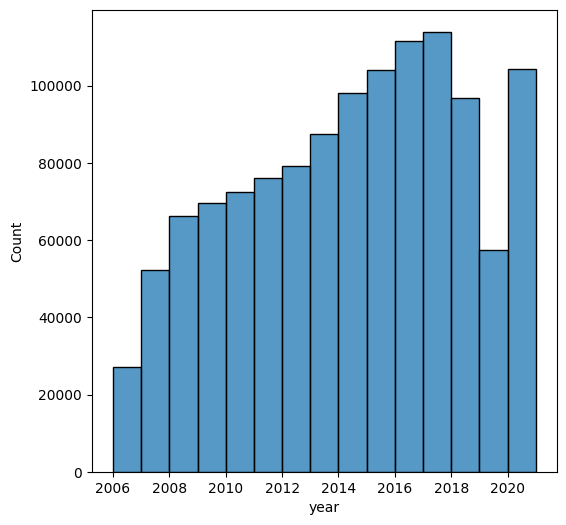

Clinical notes were uploaded to EPR
 - after clinic date: 147,268 times
 - same day as clinic date: 1,066,820 times
 - BEFORE clinic date: 2,242 times


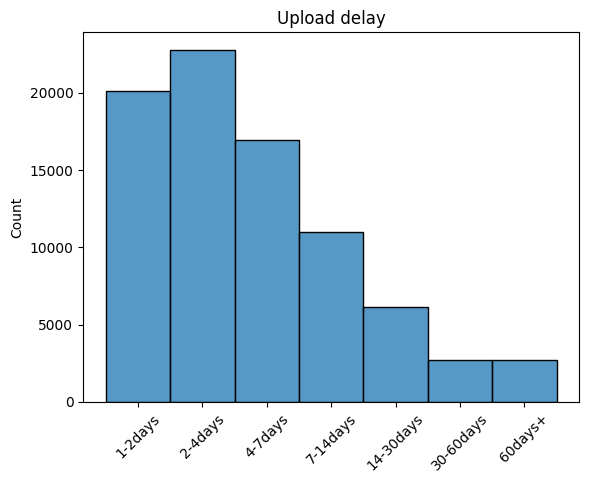

In [ ]:
# distribution across time
clinic['year'] = pd.to_datetime(clinic['clinic_date']).dt.year
fig, ax = plt.subplots(figsize=(6,6))
sns.histplot(data=clinic, x='year', binwidth=1, ax=ax)
plt.show()


# upload times
print('Clinical notes were uploaded to EPR')
mask = clinic['upload_date'] > clinic['clinic_date']
print(f' - after clinic date: {sum(mask):,} times')
mask = clinic['upload_date'] == clinic['clinic_date']
print(f' - same day as clinic date: {sum(mask):,} times')
mask = clinic['upload_date'] < clinic['clinic_date']
print(f' - BEFORE clinic date: {sum(mask):,} times')


# upload delays
diffs = pd.to_timedelta(clinic['upload_date'] - clinic['clinic_date'])
bins = [
    pd.Timedelta(days=1),
    pd.Timedelta(days=2),
    pd.Timedelta(days=4),
    pd.Timedelta(days=7),
    pd.Timedelta(days=14),
    pd.Timedelta(days=30),
    pd.Timedelta(days=60),
    pd.Timedelta(days=5000),
]
labels = [
    '1-2days', 
    '2-4days', 
    '4-7days', 
    '7-14days', 
    '14-30days',
    '30-60days', 
    '60days+'
]
diffs = pd.cut(diffs, bins=bins, labels=labels)
ax = sns.histplot(data=diffs)
ax.set(title='Upload delay')
ax.tick_params(axis='x', rotation=45)

# Missingness

<Axes: xlabel='Missing (%)', ylabel='feature'>

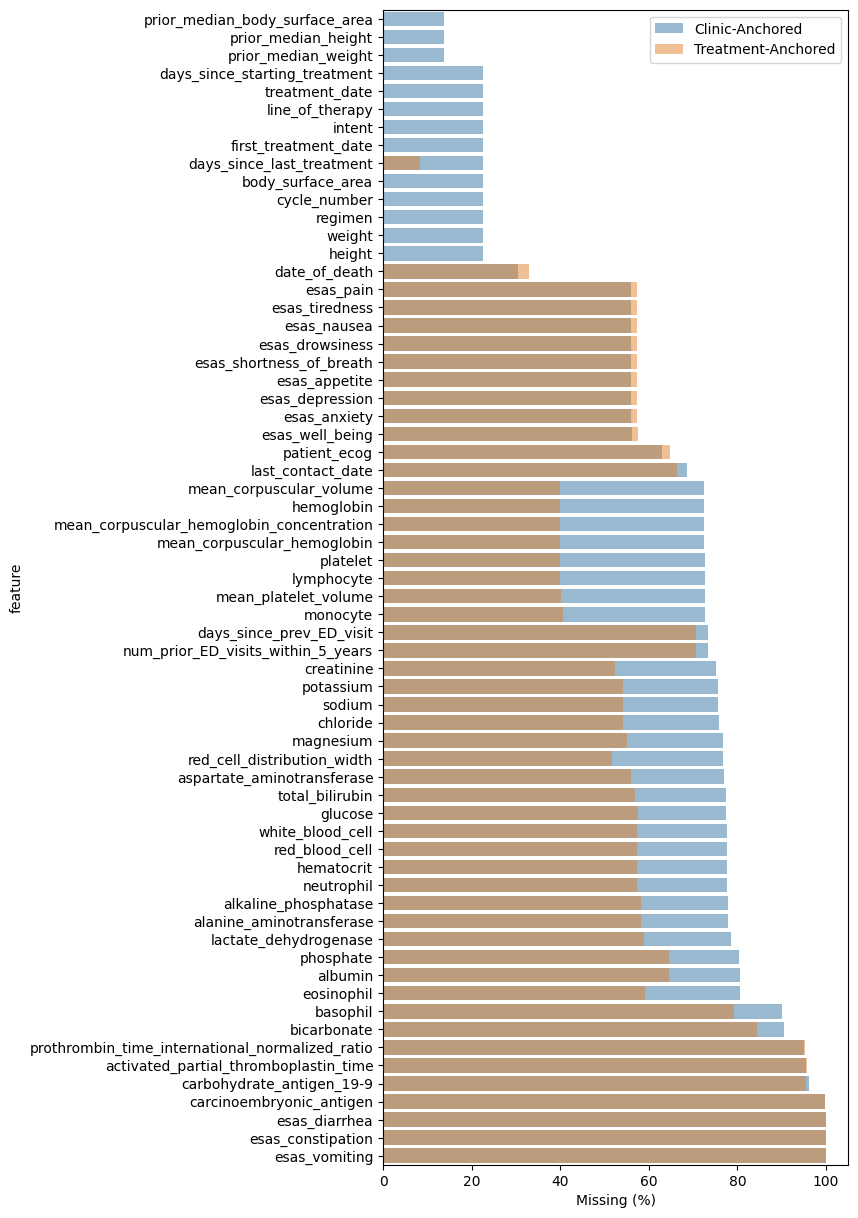

In [12]:
# Compare missingness between treatment date anchored feature dataset and clinic date anchored feature dataset
trt_anchored = pd.read_parquet('./data/processed/treatment_centered_clinical_dataset.parquet.gzip')
clinic_anchored = pd.read_parquet('./data/processed/clinic_centered_feature_dataset.parquet.gzip')
# nmissing = pd.concat([get_nmissing(trt_anchored), get_nmissing(clinic_anchored)], axis=1, keys=['trt', 'clinic'])

trt_nmissing = get_nmissing(trt_anchored).drop(index=DRUG_COLS).reset_index(names='feature')
clinic_nmissing = get_nmissing(clinic_anchored).drop(index=DRUG_COLS).reset_index(names='feature')
fig, ax = plt.subplots(figsize=(6, 15)) 
sns.barplot(data=clinic_nmissing, y='feature', x='Missing (%)', label='Clinic-Anchored', ax=ax, orient='h', alpha=0.5)
sns.barplot(data=trt_nmissing, y='feature', x='Missing (%)', label='Treatment-Anchored', ax=ax, orient='h', alpha=0.5)

In [13]:
# An alternative plot
import plotly.express as px

trt_anchored = pd.read_parquet('./data/processed/treatment_centered_clinical_dataset.parquet.gzip')
clinic_anchored = pd.read_parquet('./data/processed/clinic_centered_feature_dataset.parquet.gzip')
nmissing = pd.concat([get_nmissing(trt_anchored), get_nmissing(clinic_anchored)], keys=['Treatment-Anchored', 'Clinic-Anchored'])
nmissing = nmissing.reset_index(names=['Anchor', 'Features'])
nmissing = nmissing[~nmissing['Features'].isin(DRUG_COLS)]

fig = px.bar(
    nmissing, y='Features', x='Missing (%)', 
    color='Anchor', hover_data=['Missing (N)'], 
    orientation='h', height=1000, barmode='overlay',
    # pattern_shape='Anchor', pattern_shape_sequence=['/', '\\']
)
fig.show()